# Training the rough Bergomi model part 5

In this notebook we train a neural network for the rough Bergomi model for expiries in the range (0.40,1.00].

Be aware that the datasets are rather large.



In [1]:
import os
import plaidml.keras
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
keras.backend.backend()

'plaidml'

In [2]:
from keras.optimizers import Optimizer
from keras.legacy import interfaces
from keras import backend as K

class AdamW(Optimizer):
    def __init__(self, learning_rate=0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.0000001, w = 0.0001, name="AdamW", **kwargs):

        super(AdamW, self).__init__( **kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(learning_rate, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.w = K.variable(w, name='w')
            if epsilon is None:
                epsilon = K.epsilon()
            self.epsilon = epsilon
    
    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr


        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            p_t = p - lr * (1 / (K.sqrt(v_t + self.epsilon)) * m_t + self.w * p)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                raise NotImplementedError
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'learning_rate': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'w': float(K.get_value(self.w))}
        base_config = super(AdamW, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [3]:
class QHAdam(Optimizer):
    """QH-Adam optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta_1 < 1. Generally close to 1.
        beta_2: float, 0 < beta_2 < 1. Generally close to 1.
        neu_1: float, 0 < neu_1 < 1. Default based on paper equals 0.7
        neu_2: float, 0 < neu_2 < 1. Default based on paper equals 1
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
    # References
        - [QUASI-HYPERBOLIC MOMENTUM AND ADAM FOR DEEP LEARNING](
           https://openreview.net/pdf?id=S1fUpoR5FQ)
    """

    def __init__(self,
                 lr=0.001,
                 beta_1=0.999,
                 beta_2=0.999,
                 neu_1 = 0.7,
                 neu_2 = 1.,
                 epsilon=1e-3,
                 decay=0.,
                 amsgrad=False,
                 **kwargs):
        super(QHAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.neu_1 = K.variable(neu_1, name='neu_1')
            self.neu_2 = K.variable(neu_2, name='neu_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1


        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            m_t_adj = m_t/(1. - K.pow(self.beta_1, t))
            v_t_adj = v_t/(1. - K.pow(self.beta_2, t))
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - lr * ((1.- self.neu_1)*g + self.neu_1*(m_t_adj)) / \
                       (K.sqrt((1.-self.neu_2) * K.square(g) + self.neu_2 * vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - lr * ((1.-self.neu_1)*g + self.neu_1*(m_t_adj)) / \
                       (K.sqrt((1.-self.neu_2)*K.square(g) + self.neu_2 * v_t_adj) + self.epsilon)
            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'neu_1': float(K.get_value(self.neu_1)),
                  'neu_2': float(K.get_value(self.neu_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(QHAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Load, split and scale the datasets

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os, pandas as pd, numpy as np
wd = os.getcwd()

path_seperator = os.path.sep

optimizers=[keras.optimizers.Adam(), AdamW(), QHAdam()]
data = [1,2,3,4,5,6]

# Load contract grid:
logMoneyness = pd.read_csv(wd + '/data/logMoneyness.txt', delimiter=",", header = None).values
expiries = pd.read_csv(wd + '/data/expiries.txt', delimiter=",", header = None).values

# Set useful parameters:
nIn = 25
nOut = 175
nXi = 22

# Load training data:
data_train = pd.read_csv(wd + '/data/training_and_test_data/rbergomi_training_data_5.csv', delimiter=",").values
x_train = data_train[:,:nIn]


y_train = data_train[:,nIn:nIn+nOut]
data_train = None

# Load test data:
data_test = pd.read_csv(wd + '/data/training_and_test_data/rbergomi_test_data_5.csv', delimiter=",").values
x_valid = data_test[:,:nIn]
y_valid = data_test[:,nIn:nIn+nOut]
data_test = None

# Normalise data:
from sklearn.preprocessing import StandardScaler

tmp1 = np.reshape(np.array([0.50,3.50,0.00]), (1, 3))
tmp2 = np.reshape(np.array([0.00,0.75,-1.00]), (1, 3))
ub = np.concatenate((tmp1,np.tile(1,(1,nXi))),1)
lb = np.concatenate((tmp2,np.tile(0.0025,(1,nXi))),1)

def myscale(x):
    res=np.zeros(nIn)
    for i in range(nIn):
        res[i]=(x[i] - (ub[0,i] + lb[0,i])*0.5) * 2 / (ub[0,i] - lb[0,i])
        
    return res

def myinverse(x):
    res=np.zeros(nIn)
    for i in range(nIn):
        res[i]=x[i]*(ub[0,i] - lb[0,i]) *0.5 + (ub[0,i] + lb[0,i])*0.5
        
    return res

# Scale inputs:
x_train_mod = np.array([myscale(x) for x in x_train])
x_valid_mod = np.array([myscale(x) for x in x_valid])

# Scale and normalise output:
scale_y =  StandardScaler()
y_train_mod = scale_y.fit_transform(y_train)
y_valid_mod = scale_y.transform(y_valid)

INFO:plaidml:Opening device "metal_amd_radeon_pro_450.0"


### Define utility functions

In [5]:
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
#keras.backend.set_floatx('float64')

def GetNetwork(nIn,nOut,nNodes,nLayers,actFun):
    # Description: Creates a neural network of a specified structure
    input1 = keras.layers.Input(shape=(nIn,))
    layerTmp = keras.layers.Dense(nNodes,activation = actFun)(input1) 
    for i in range(nLayers-1):
        layerTmp = keras.layers.Dense(nNodes,activation = actFun)(layerTmp) 
    output1 = keras.layers.Dense(nOut,activation = 'linear')(layerTmp)
    return(keras.models.Model(inputs=input1, outputs=output1))

def TrainNetwork(nn,batchsize,numEpochs,objFun,optimizer,xTrain,yTrain,xTest,yTest):
    # Description: Trains a neural network and returns the network including the history
    # of the training process.
    nn.compile(loss = objFun, optimizer = optimizer)
    model.summary()
    history = nn.fit(xTrain, 
                     yTrain, 
                     batch_size = batchsize,
                     validation_data = (xTest,yTest),
                     epochs = numEpochs, 
                     verbose = True, 
                     shuffle=1) 
    return nn,history.history['loss'],history.history['val_loss']

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square( y_pred - y_true )))

### Define and train neural network
<span style="color:red">This section can be skipped! Just go straight to "Load network" and load the already trained model</span>

In [6]:
# Set seed
import random
random.seed(455165)

models = {}

for opti in optimizers:
    # Define model:
    model = GetNetwork(nIn,nOut,200,3,'elu')

    # Train network
    model,loss1,vloss1 = TrainNetwork(model,64,500,root_mean_squared_error,   opti,   x_train_mod,y_train_mod,x_valid_mod,y_valid_mod)
    model,loss2,vloss2 = TrainNetwork(model,5000,200,root_mean_squared_error,   opti,   x_train_mod,y_train_mod,x_valid_mod,y_valid_mod)
    models[opti.__class__.__name__] = [model, loss1, vloss1, loss2, vloss2]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               5200      
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 175)               35175     
Total params: 120,775
Trainable params: 120,775
Non-trainable params: 0
_________________________________________________________________
Train on 136000 samples, validate on 24000 samples
Epoch 1/500
136000/136000 [==============================] - 20s 146us/step - loss: 0

136000/136000 [==============================] - 24s 176us/step - loss: 0.0160 - val_loss: 0.0195
Epoch 66/500
136000/136000 [==============================] - 24s 178us/step - loss: 0.0159 - val_loss: 0.0183
Epoch 67/500
136000/136000 [==============================] - 23s 173us/step - loss: 0.0159 - val_loss: 0.0129
Epoch 68/500
136000/136000 [==============================] - 24s 177us/step - loss: 0.0160 - val_loss: 0.0145
Epoch 69/500
136000/136000 [==============================] - 24s 176us/step - loss: 0.0157 - val_loss: 0.0177
Epoch 70/500
136000/136000 [==============================] - 23s 171us/step - loss: 0.0158 - val_loss: 0.0142
Epoch 71/500
136000/136000 [==============================] - 24s 175us/step - loss: 0.0157 - val_loss: 0.0224
Epoch 72/500
136000/136000 [==============================] - 23s 171us/step - loss: 0.0155 - val_loss: 0.0126
Epoch 73/500
136000/136000 [==============================] - 23s 171us/step - loss: 0.0156 - val_loss: 0.0167
Epoch 74/500
1

136000/136000 [==============================] - 23s 171us/step - loss: 0.0134 - val_loss: 0.0150
Epoch 139/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0133 - val_loss: 0.0149
Epoch 140/500
136000/136000 [==============================] - 23s 173us/step - loss: 0.0131 - val_loss: 0.0128
Epoch 141/500
136000/136000 [==============================] - 23s 173us/step - loss: 0.0131 - val_loss: 0.0120
Epoch 142/500
136000/136000 [==============================] - 24s 176us/step - loss: 0.0132 - val_loss: 0.0127
Epoch 143/500
136000/136000 [==============================] - 24s 178us/step - loss: 0.0131 - val_loss: 0.0128
Epoch 144/500
136000/136000 [==============================] - 24s 174us/step - loss: 0.0132 - val_loss: 0.0116
Epoch 145/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0131 - val_loss: 0.0150
Epoch 146/500
136000/136000 [==============================] - 23s 171us/step - loss: 0.0131 - val_loss: 0.0113
Epoch 

136000/136000 [==============================] - 24s 175us/step - loss: 0.0124 - val_loss: 0.0146
Epoch 212/500
136000/136000 [==============================] - 24s 178us/step - loss: 0.0123 - val_loss: 0.0104
Epoch 213/500
136000/136000 [==============================] - 24s 176us/step - loss: 0.0120 - val_loss: 0.0113
Epoch 214/500
136000/136000 [==============================] - 23s 171us/step - loss: 0.0120 - val_loss: 0.0177
Epoch 215/500
136000/136000 [==============================] - 23s 172us/step - loss: 0.0121 - val_loss: 0.0105
Epoch 216/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0121 - val_loss: 0.0124
Epoch 217/500
136000/136000 [==============================] - 24s 174us/step - loss: 0.0120 - val_loss: 0.0123
Epoch 218/500
136000/136000 [==============================] - 24s 174us/step - loss: 0.0121 - val_loss: 0.0138
Epoch 219/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0122 - val_loss: 0.0142
Epoch 

136000/136000 [==============================] - 24s 174us/step - loss: 0.0116 - val_loss: 0.0117
Epoch 285/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0115 - val_loss: 0.0109
Epoch 286/500
136000/136000 [==============================] - 24s 175us/step - loss: 0.0115 - val_loss: 0.0105
Epoch 287/500
136000/136000 [==============================] - 23s 167us/step - loss: 0.0114 - val_loss: 0.0127
Epoch 288/500
136000/136000 [==============================] - 23s 167us/step - loss: 0.0115 - val_loss: 0.0103
Epoch 289/500
136000/136000 [==============================] - 24s 175us/step - loss: 0.0115 - val_loss: 0.0104
Epoch 290/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0115 - val_loss: 0.0109
Epoch 291/500
136000/136000 [==============================] - 23s 171us/step - loss: 0.0114 - val_loss: 0.0118
Epoch 292/500
136000/136000 [==============================] - 24s 177us/step - loss: 0.0116 - val_loss: 0.0105
Epoch 

136000/136000 [==============================] - 24s 174us/step - loss: 0.0112 - val_loss: 0.0126
Epoch 358/500
136000/136000 [==============================] - 24s 174us/step - loss: 0.0111 - val_loss: 0.0135
Epoch 359/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0111 - val_loss: 0.0112
Epoch 360/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0111 - val_loss: 0.0102
Epoch 361/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0112 - val_loss: 0.0107
Epoch 362/500
136000/136000 [==============================] - 23s 172us/step - loss: 0.0110 - val_loss: 0.0106
Epoch 363/500
136000/136000 [==============================] - 24s 175us/step - loss: 0.0109 - val_loss: 0.0096
Epoch 364/500
136000/136000 [==============================] - 24s 174us/step - loss: 0.0111 - val_loss: 0.0160
Epoch 365/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0111 - val_loss: 0.0137
Epoch 

136000/136000 [==============================] - 24s 175us/step - loss: 0.0109 - val_loss: 0.0103
Epoch 431/500
136000/136000 [==============================] - 23s 172us/step - loss: 0.0108 - val_loss: 0.0108
Epoch 432/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0110 - val_loss: 0.0098
Epoch 433/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0108 - val_loss: 0.0110
Epoch 434/500
136000/136000 [==============================] - 24s 174us/step - loss: 0.0109 - val_loss: 0.0102
Epoch 435/500
136000/136000 [==============================] - 24s 177us/step - loss: 0.0108 - val_loss: 0.0141
Epoch 436/500
136000/136000 [==============================] - 23s 169us/step - loss: 0.0109 - val_loss: 0.0112
Epoch 437/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0109 - val_loss: 0.0106
Epoch 438/500
136000/136000 [==============================] - 24s 175us/step - loss: 0.0108 - val_loss: 0.0102
Epoch 

136000/136000 [==============================] - 4s 29us/step - loss: 0.0742 - val_loss: 0.0365
Epoch 2/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0224 - val_loss: 0.0167
Epoch 3/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0136 - val_loss: 0.0102
Epoch 4/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0114 - val_loss: 0.0115
Epoch 5/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0101 - val_loss: 0.0098
Epoch 6/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0093 - val_loss: 0.0094
Epoch 7/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0087 - val_loss: 0.0110
Epoch 8/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0088 - val_loss: 0.0079
Epoch 9/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0083 - val_loss: 0.0087
Epoch 10/200
136000/136000 [============

136000/136000 [==============================] - 2s 12us/step - loss: 0.0074 - val_loss: 0.0074
Epoch 77/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0074 - val_loss: 0.0075
Epoch 78/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0074 - val_loss: 0.0085
Epoch 79/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0077 - val_loss: 0.0074
Epoch 80/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0074 - val_loss: 0.0077
Epoch 81/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0075 - val_loss: 0.0077
Epoch 82/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0075 - val_loss: 0.0080
Epoch 83/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0075 - val_loss: 0.0080
Epoch 84/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0075 - val_loss: 0.0075
Epoch 85/200
136000/136000 [====

Epoch 151/200
136000/136000 [==============================] - 2s 11us/step - loss: 0.0074 - val_loss: 0.0081
Epoch 152/200
136000/136000 [==============================] - 2s 11us/step - loss: 0.0075 - val_loss: 0.0073
Epoch 153/200
136000/136000 [==============================] - 2s 15us/step - loss: 0.0074 - val_loss: 0.0075
Epoch 154/200
136000/136000 [==============================] - 2s 16us/step - loss: 0.0073 - val_loss: 0.0076
Epoch 155/200
136000/136000 [==============================] - 2s 17us/step - loss: 0.0074 - val_loss: 0.0073
Epoch 156/200
136000/136000 [==============================] - 2s 16us/step - loss: 0.0074 - val_loss: 0.0073
Epoch 157/200
136000/136000 [==============================] - 2s 17us/step - loss: 0.0074 - val_loss: 0.0077
Epoch 158/200
136000/136000 [==============================] - 2s 17us/step - loss: 0.0074 - val_loss: 0.0072
Epoch 159/200
136000/136000 [==============================] - 2s 18us/step - loss: 0.0075 - val_loss: 0.0074
Epoch 160/

Epoch 16/500
136000/136000 [==============================] - 25s 181us/step - loss: 0.0234 - val_loss: 0.0209
Epoch 17/500
136000/136000 [==============================] - 25s 186us/step - loss: 0.0225 - val_loss: 0.0203
Epoch 18/500
136000/136000 [==============================] - 26s 188us/step - loss: 0.0234 - val_loss: 0.0213
Epoch 19/500
136000/136000 [==============================] - 26s 190us/step - loss: 0.0220 - val_loss: 0.0217
Epoch 20/500
136000/136000 [==============================] - 26s 188us/step - loss: 0.0218 - val_loss: 0.0248
Epoch 21/500
136000/136000 [==============================] - 26s 192us/step - loss: 0.0214 - val_loss: 0.0285
Epoch 22/500
136000/136000 [==============================] - 26s 189us/step - loss: 0.0215 - val_loss: 0.0311
Epoch 23/500
136000/136000 [==============================] - 26s 193us/step - loss: 0.0215 - val_loss: 0.0268
Epoch 24/500
136000/136000 [==============================] - 26s 189us/step - loss: 0.0203 - val_loss: 0.0227
E

Epoch 90/500
136000/136000 [==============================] - 24s 177us/step - loss: 0.0144 - val_loss: 0.0165
Epoch 91/500
136000/136000 [==============================] - 24s 175us/step - loss: 0.0144 - val_loss: 0.0140
Epoch 92/500
136000/136000 [==============================] - 23s 172us/step - loss: 0.0142 - val_loss: 0.0125
Epoch 93/500
136000/136000 [==============================] - 23s 169us/step - loss: 0.0142 - val_loss: 0.0115
Epoch 94/500
136000/136000 [==============================] - 24s 179us/step - loss: 0.0144 - val_loss: 0.0111
Epoch 95/500
136000/136000 [==============================] - 24s 179us/step - loss: 0.0143 - val_loss: 0.0128
Epoch 96/500
136000/136000 [==============================] - 23s 170us/step - loss: 0.0142 - val_loss: 0.0163
Epoch 97/500
136000/136000 [==============================] - 24s 180us/step - loss: 0.0144 - val_loss: 0.0120
Epoch 98/500
136000/136000 [==============================] - 24s 173us/step - loss: 0.0138 - val_loss: 0.0134
E

136000/136000 [==============================] - 24s 176us/step - loss: 0.0126 - val_loss: 0.0128
Epoch 164/500
136000/136000 [==============================] - 25s 180us/step - loss: 0.0126 - val_loss: 0.0116
Epoch 165/500
136000/136000 [==============================] - 24s 176us/step - loss: 0.0124 - val_loss: 0.0126
Epoch 166/500
136000/136000 [==============================] - 24s 174us/step - loss: 0.0126 - val_loss: 0.0107
Epoch 167/500
136000/136000 [==============================] - 23s 170us/step - loss: 0.0123 - val_loss: 0.0206
Epoch 168/500
136000/136000 [==============================] - 24s 179us/step - loss: 0.0125 - val_loss: 0.0123
Epoch 169/500
136000/136000 [==============================] - 24s 174us/step - loss: 0.0124 - val_loss: 0.0138
Epoch 170/500
136000/136000 [==============================] - 23s 171us/step - loss: 0.0124 - val_loss: 0.0124
Epoch 171/500
136000/136000 [==============================] - 24s 175us/step - loss: 0.0124 - val_loss: 0.0116
Epoch 

136000/136000 [==============================] - 24s 178us/step - loss: 0.0116 - val_loss: 0.0131
Epoch 237/500
136000/136000 [==============================] - 23s 168us/step - loss: 0.0117 - val_loss: 0.0147
Epoch 238/500
136000/136000 [==============================] - 23s 173us/step - loss: 0.0116 - val_loss: 0.0103
Epoch 239/500
136000/136000 [==============================] - 24s 180us/step - loss: 0.0118 - val_loss: 0.0121
Epoch 240/500
136000/136000 [==============================] - 24s 177us/step - loss: 0.0116 - val_loss: 0.0116
Epoch 241/500
136000/136000 [==============================] - 24s 179us/step - loss: 0.0117 - val_loss: 0.0123
Epoch 242/500
136000/136000 [==============================] - 24s 178us/step - loss: 0.0116 - val_loss: 0.0132
Epoch 243/500
136000/136000 [==============================] - 24s 174us/step - loss: 0.0114 - val_loss: 0.0116
Epoch 244/500
136000/136000 [==============================] - 24s 174us/step - loss: 0.0116 - val_loss: 0.0141
Epoch 

136000/136000 [==============================] - 24s 177us/step - loss: 0.0112 - val_loss: 0.0097
Epoch 310/500
136000/136000 [==============================] - 24s 175us/step - loss: 0.0111 - val_loss: 0.0123
Epoch 311/500
136000/136000 [==============================] - 24s 179us/step - loss: 0.0110 - val_loss: 0.0096
Epoch 312/500
136000/136000 [==============================] - 24s 178us/step - loss: 0.0112 - val_loss: 0.0103
Epoch 313/500
136000/136000 [==============================] - 24s 176us/step - loss: 0.0111 - val_loss: 0.0106
Epoch 314/500
136000/136000 [==============================] - 24s 180us/step - loss: 0.0112 - val_loss: 0.0118
Epoch 315/500
136000/136000 [==============================] - 24s 175us/step - loss: 0.0111 - val_loss: 0.0107
Epoch 316/500
136000/136000 [==============================] - 24s 176us/step - loss: 0.0113 - val_loss: 0.0110
Epoch 317/500
136000/136000 [==============================] - 24s 178us/step - loss: 0.0110 - val_loss: 0.0101
Epoch 

136000/136000 [==============================] - 24s 178us/step - loss: 0.0107 - val_loss: 0.0103
Epoch 383/500
136000/136000 [==============================] - 24s 177us/step - loss: 0.0107 - val_loss: 0.0102
Epoch 384/500
136000/136000 [==============================] - 24s 177us/step - loss: 0.0108 - val_loss: 0.0100
Epoch 385/500
136000/136000 [==============================] - 24s 179us/step - loss: 0.0107 - val_loss: 0.0102
Epoch 386/500
136000/136000 [==============================] - 24s 178us/step - loss: 0.0108 - val_loss: 0.0125
Epoch 387/500
136000/136000 [==============================] - 24s 178us/step - loss: 0.0107 - val_loss: 0.0118
Epoch 388/500
136000/136000 [==============================] - 24s 178us/step - loss: 0.0108 - val_loss: 0.0102
Epoch 389/500
136000/136000 [==============================] - 24s 179us/step - loss: 0.0108 - val_loss: 0.0102
Epoch 390/500
136000/136000 [==============================] - 23s 169us/step - loss: 0.0105 - val_loss: 0.0094
Epoch 

136000/136000 [==============================] - 24s 179us/step - loss: 0.0106 - val_loss: 0.0096
Epoch 456/500
136000/136000 [==============================] - 24s 177us/step - loss: 0.0104 - val_loss: 0.0096
Epoch 457/500
136000/136000 [==============================] - 24s 178us/step - loss: 0.0104 - val_loss: 0.0093
Epoch 458/500
136000/136000 [==============================] - 24s 177us/step - loss: 0.0104 - val_loss: 0.0132
Epoch 459/500
136000/136000 [==============================] - 24s 176us/step - loss: 0.0104 - val_loss: 0.0093
Epoch 460/500
136000/136000 [==============================] - 24s 176us/step - loss: 0.0104 - val_loss: 0.0120
Epoch 461/500
136000/136000 [==============================] - 24s 178us/step - loss: 0.0103 - val_loss: 0.0106
Epoch 462/500
136000/136000 [==============================] - 24s 177us/step - loss: 0.0103 - val_loss: 0.0093
Epoch 463/500
136000/136000 [==============================] - 24s 179us/step - loss: 0.0104 - val_loss: 0.0090
Epoch 

136000/136000 [==============================] - 2s 13us/step - loss: 0.0074 - val_loss: 0.0076
Epoch 20/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0072 - val_loss: 0.0081
Epoch 21/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0073 - val_loss: 0.0078
Epoch 22/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0073 - val_loss: 0.0077
Epoch 23/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0073 - val_loss: 0.0072
Epoch 24/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0073 - val_loss: 0.0074
Epoch 25/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0072 - val_loss: 0.0085
Epoch 26/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0076 - val_loss: 0.0072
Epoch 27/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0072 - val_loss: 0.0071
Epoch 28/200
136000/136000 [====

136000/136000 [==============================] - 2s 13us/step - loss: 0.0071 - val_loss: 0.0076
Epoch 95/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0071 - val_loss: 0.0073
Epoch 96/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0071 - val_loss: 0.0074
Epoch 97/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0072 - val_loss: 0.0071
Epoch 98/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0072 - val_loss: 0.0078
Epoch 99/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0072 - val_loss: 0.0076
Epoch 100/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0071 - val_loss: 0.0071
Epoch 101/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0072 - val_loss: 0.0073
Epoch 102/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0070 - val_loss: 0.0074
Epoch 103/200
136000/136000 [

136000/136000 [==============================] - 2s 13us/step - loss: 0.0072 - val_loss: 0.0071
Epoch 169/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0072 - val_loss: 0.0071
Epoch 170/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0071 - val_loss: 0.0074
Epoch 171/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0071 - val_loss: 0.0072
Epoch 172/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0071 - val_loss: 0.0072
Epoch 173/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0071 - val_loss: 0.0070
Epoch 174/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0071 - val_loss: 0.0076
Epoch 175/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0071 - val_loss: 0.0072
Epoch 176/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0070 - val_loss: 0.0077
Epoch 177/200
136000/136

Epoch 33/500
136000/136000 [==============================] - 25s 182us/step - loss: 0.0251 - val_loss: 0.0283
Epoch 34/500
136000/136000 [==============================] - 25s 186us/step - loss: 0.0249 - val_loss: 0.0249
Epoch 35/500
136000/136000 [==============================] - 25s 186us/step - loss: 0.0246 - val_loss: 0.0210
Epoch 36/500
136000/136000 [==============================] - 26s 188us/step - loss: 0.0244 - val_loss: 0.0242
Epoch 37/500
136000/136000 [==============================] - 25s 182us/step - loss: 0.0241 - val_loss: 0.0195
Epoch 38/500
136000/136000 [==============================] - 25s 185us/step - loss: 0.0240 - val_loss: 0.0278
Epoch 39/500
136000/136000 [==============================] - 26s 193us/step - loss: 0.0237 - val_loss: 0.0252
Epoch 40/500
136000/136000 [==============================] - 27s 195us/step - loss: 0.0235 - val_loss: 0.0302
Epoch 41/500
136000/136000 [==============================] - 27s 196us/step - loss: 0.0233 - val_loss: 0.0219
E

136000/136000 [==============================] - 25s 187us/step - loss: 0.0169 - val_loss: 0.0157
Epoch 107/500
136000/136000 [==============================] - 26s 188us/step - loss: 0.0168 - val_loss: 0.0196
Epoch 108/500
136000/136000 [==============================] - 26s 189us/step - loss: 0.0167 - val_loss: 0.0147
Epoch 109/500
136000/136000 [==============================] - 26s 190us/step - loss: 0.0167 - val_loss: 0.0170
Epoch 110/500
136000/136000 [==============================] - 26s 190us/step - loss: 0.0166 - val_loss: 0.0181
Epoch 111/500
136000/136000 [==============================] - 24s 180us/step - loss: 0.0166 - val_loss: 0.0152
Epoch 112/500
136000/136000 [==============================] - 26s 189us/step - loss: 0.0166 - val_loss: 0.0135
Epoch 113/500
136000/136000 [==============================] - 26s 189us/step - loss: 0.0164 - val_loss: 0.0141
Epoch 114/500
136000/136000 [==============================] - 25s 185us/step - loss: 0.0165 - val_loss: 0.0141
Epoch 

136000/136000 [==============================] - 26s 189us/step - loss: 0.0143 - val_loss: 0.0161
Epoch 180/500
136000/136000 [==============================] - 26s 192us/step - loss: 0.0143 - val_loss: 0.0127
Epoch 181/500
136000/136000 [==============================] - 25s 183us/step - loss: 0.0143 - val_loss: 0.0140
Epoch 182/500
136000/136000 [==============================] - 25s 182us/step - loss: 0.0143 - val_loss: 0.0130
Epoch 183/500
136000/136000 [==============================] - 25s 185us/step - loss: 0.0143 - val_loss: 0.0150
Epoch 184/500
136000/136000 [==============================] - 26s 189us/step - loss: 0.0142 - val_loss: 0.0121
Epoch 185/500
136000/136000 [==============================] - 26s 190us/step - loss: 0.0142 - val_loss: 0.0158
Epoch 186/500
136000/136000 [==============================] - 26s 192us/step - loss: 0.0142 - val_loss: 0.0141
Epoch 187/500
136000/136000 [==============================] - 26s 189us/step - loss: 0.0142 - val_loss: 0.0134
Epoch 

136000/136000 [==============================] - 25s 182us/step - loss: 0.0131 - val_loss: 0.0137
Epoch 253/500
136000/136000 [==============================] - 25s 187us/step - loss: 0.0131 - val_loss: 0.0128
Epoch 254/500
136000/136000 [==============================] - 24s 180us/step - loss: 0.0131 - val_loss: 0.0113
Epoch 255/500
136000/136000 [==============================] - 25s 185us/step - loss: 0.0131 - val_loss: 0.0146
Epoch 256/500
136000/136000 [==============================] - 25s 182us/step - loss: 0.0130 - val_loss: 0.0129
Epoch 257/500
136000/136000 [==============================] - 26s 188us/step - loss: 0.0131 - val_loss: 0.0153
Epoch 258/500
136000/136000 [==============================] - 25s 182us/step - loss: 0.0130 - val_loss: 0.0143
Epoch 259/500
136000/136000 [==============================] - 24s 174us/step - loss: 0.0130 - val_loss: 0.0124
Epoch 260/500
136000/136000 [==============================] - 25s 184us/step - loss: 0.0130 - val_loss: 0.0102
Epoch 

136000/136000 [==============================] - 26s 190us/step - loss: 0.0123 - val_loss: 0.0129
Epoch 326/500
136000/136000 [==============================] - 26s 191us/step - loss: 0.0123 - val_loss: 0.0125
Epoch 327/500
136000/136000 [==============================] - 26s 194us/step - loss: 0.0122 - val_loss: 0.0096
Epoch 328/500
136000/136000 [==============================] - 26s 191us/step - loss: 0.0122 - val_loss: 0.0115
Epoch 329/500
136000/136000 [==============================] - 26s 190us/step - loss: 0.0122 - val_loss: 0.0111
Epoch 330/500
136000/136000 [==============================] - 26s 190us/step - loss: 0.0122 - val_loss: 0.0111
Epoch 331/500
136000/136000 [==============================] - 26s 190us/step - loss: 0.0122 - val_loss: 0.0115
Epoch 332/500
136000/136000 [==============================] - 26s 192us/step - loss: 0.0122 - val_loss: 0.0108
Epoch 333/500
136000/136000 [==============================] - 26s 188us/step - loss: 0.0122 - val_loss: 0.0130
Epoch 

136000/136000 [==============================] - 26s 190us/step - loss: 0.0117 - val_loss: 0.0117
Epoch 399/500
136000/136000 [==============================] - 26s 189us/step - loss: 0.0116 - val_loss: 0.0118
Epoch 400/500
136000/136000 [==============================] - 26s 189us/step - loss: 0.0116 - val_loss: 0.0115
Epoch 401/500
136000/136000 [==============================] - 26s 191us/step - loss: 0.0116 - val_loss: 0.0109
Epoch 402/500
136000/136000 [==============================] - 26s 190us/step - loss: 0.0116 - val_loss: 0.0110
Epoch 403/500
136000/136000 [==============================] - 26s 191us/step - loss: 0.0116 - val_loss: 0.0119
Epoch 404/500
136000/136000 [==============================] - 26s 190us/step - loss: 0.0116 - val_loss: 0.0110
Epoch 405/500
136000/136000 [==============================] - 26s 194us/step - loss: 0.0116 - val_loss: 0.0099
Epoch 406/500
136000/136000 [==============================] - 26s 188us/step - loss: 0.0116 - val_loss: 0.0115
Epoch 

136000/136000 [==============================] - 26s 190us/step - loss: 0.0111 - val_loss: 0.0111
Epoch 472/500
136000/136000 [==============================] - 25s 184us/step - loss: 0.0112 - val_loss: 0.0095
Epoch 473/500
136000/136000 [==============================] - 26s 188us/step - loss: 0.0111 - val_loss: 0.0104
Epoch 474/500
136000/136000 [==============================] - 26s 190us/step - loss: 0.0111 - val_loss: 0.0097
Epoch 475/500
136000/136000 [==============================] - 25s 182us/step - loss: 0.0111 - val_loss: 0.0104
Epoch 476/500
136000/136000 [==============================] - 25s 186us/step - loss: 0.0111 - val_loss: 0.0132
Epoch 477/500
136000/136000 [==============================] - 25s 185us/step - loss: 0.0111 - val_loss: 0.0094
Epoch 478/500
136000/136000 [==============================] - 25s 184us/step - loss: 0.0111 - val_loss: 0.0108
Epoch 479/500
136000/136000 [==============================] - 26s 191us/step - loss: 0.0111 - val_loss: 0.0117
Epoch 

Epoch 36/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0113 - val_loss: 0.0109
Epoch 37/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0113 - val_loss: 0.0112
Epoch 38/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0113 - val_loss: 0.0118
Epoch 39/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0112 - val_loss: 0.0107
Epoch 40/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0111 - val_loss: 0.0111
Epoch 41/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0111 - val_loss: 0.0111
Epoch 42/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0110 - val_loss: 0.0113
Epoch 43/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0109 - val_loss: 0.0113
Epoch 44/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0109 - val_loss: 0.0111
Epoch 45/200
136000

136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0109
Epoch 112/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0103
Epoch 113/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0111
Epoch 114/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0103 - val_loss: 0.0109
Epoch 115/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0110
Epoch 116/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0103 - val_loss: 0.0107
Epoch 117/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0103 - val_loss: 0.0110
Epoch 118/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0102 - val_loss: 0.0112
Epoch 119/200
136000/136000 [==============================] - 2s 12us/step - loss: 0.0105 - val_loss: 0.0111
Epoch 120/200
136000/136

136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0111
Epoch 186/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0115
Epoch 187/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0103 - val_loss: 0.0117
Epoch 188/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0113
Epoch 189/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0107
Epoch 190/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0106
Epoch 191/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0107
Epoch 192/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0104
Epoch 193/200
136000/136000 [==============================] - 2s 13us/step - loss: 0.0104 - val_loss: 0.0107
Epoch 194/200
136000/136

In [7]:
import pandas as pd
for key, value in models.items():
    dl = {'loss1_' + key: value[1], 'vloss1_' + key: value[2]}
    dvl = {'loss2_' + key: value[3], 'vloss2_' + key: value[4]}
    df = pd.DataFrame(data=dl)

    df.to_csv(wd + '/data/neural_network_weights/rbergomi/' + 'rbergomi_model_5_' + key + '_' + 'loss1' + '.csv', encoding='utf-8', index=False)
    df = pd.DataFrame(data=dvl)

    df.to_csv(wd + '/data/neural_network_weights/rbergomi/' + 'rbergomi_model_5_' + key + '_' + 'loss2' + '.csv', encoding='utf-8', index=False)


### Save network
<span style="color:red">This section can be skipped! Just go straight to "Load network" and load the already trained model</span>


In [8]:
for key, value in models.items():
    # Save model:
    value[0].save(wd + '/data/neural_network_weights/rbergomi/rbergomi_model_5_' + key + '.h5')

    # Save weights (and scalings) in JSON format:
    # - You need to install 'json-tricks' first.
    # - We need this file for proper import into Matlab, R... etc.
    weights_and_more = value[0].get_weights()
    weights_and_more.append(0.5*(ub + lb))
    weights_and_more.append(np.power(0.5*(ub - lb),2))
    weights_and_more.append(scale_y.mean_)
    weights_and_more.append(scale_y.var_)

    import codecs, json 
    for idx, val in enumerate(weights_and_more):
        weights_and_more[idx] = weights_and_more[idx].tolist()

    json_str = json.dumps(weights_and_more)

    text_file = open(wd + "/data/neural_network_weights/rbergomi/rbergomi_weights_5_" + key + ".json", "w")
    text_file.write(json_str)
    text_file.close()

### Load network

In [9]:
# Load already trained neural network: 
model = keras.models.load_model(wd + '/data/neural_network_weights/rbergomi/rbergomi_model_5_adam.h5', 
                                custom_objects={'root_mean_squared_error': root_mean_squared_error, 'QHAdam': QHAdam, 'AdamW' : AdamW})

### Validate approximation

Model Parameters (H,eta,rho,xi1,xi2,...):  [ 0.10233071  2.46366781 -0.80421258  0.0711089   0.0868111   0.09131601
  0.07464078  0.08951974  0.08440326  0.10166941  0.08605685  0.11479766
  0.11478723  0.15638124  0.16454287  0.19199008  0.2132066   0.20111456
  0.27276635  0.32668705  0.41053279  0.5308719   0.52416542  0.59583366
  0.65841607]


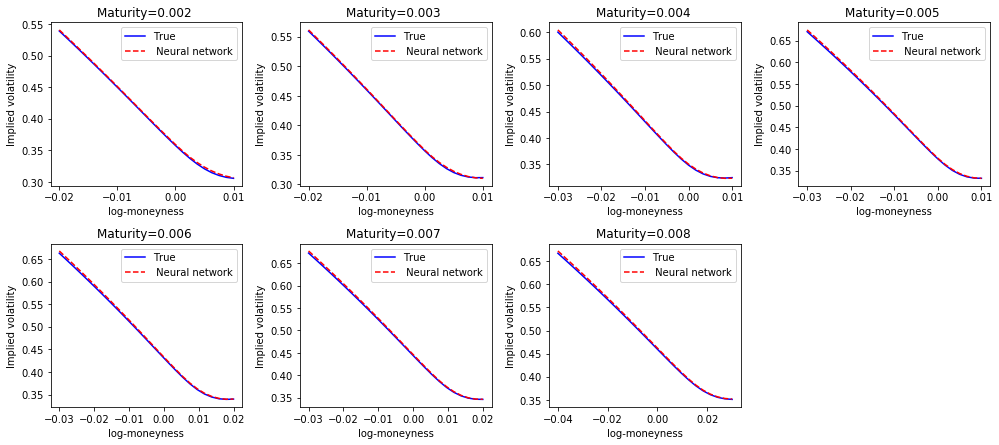

Model Parameters (H,eta,rho,xi1,xi2,...):  [ 0.10233071  2.46366781 -0.80421258  0.0711089   0.0868111   0.09131601
  0.07464078  0.08951974  0.08440326  0.10166941  0.08605685  0.11479766
  0.11478723  0.15638124  0.16454287  0.19199008  0.2132066   0.20111456
  0.27276635  0.32668705  0.41053279  0.5308719   0.52416542  0.59583366
  0.65841607]


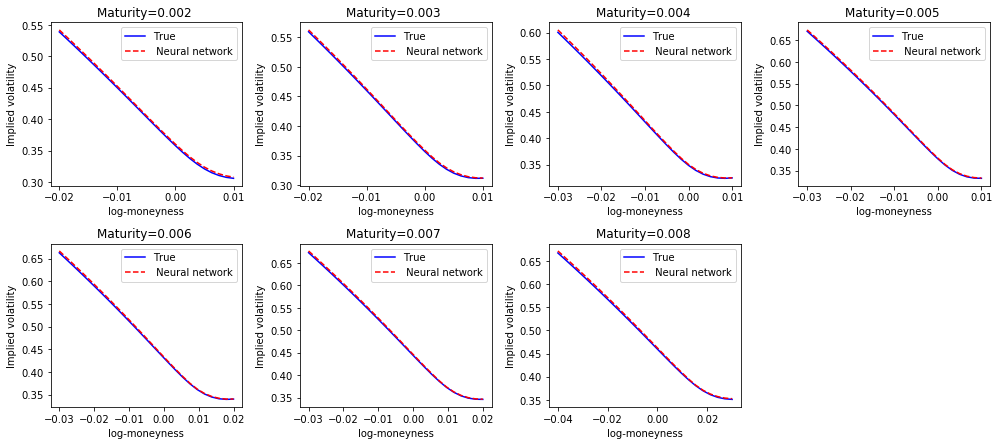

Model Parameters (H,eta,rho,xi1,xi2,...):  [ 0.10233071  2.46366781 -0.80421258  0.0711089   0.0868111   0.09131601
  0.07464078  0.08951974  0.08440326  0.10166941  0.08605685  0.11479766
  0.11478723  0.15638124  0.16454287  0.19199008  0.2132066   0.20111456
  0.27276635  0.32668705  0.41053279  0.5308719   0.52416542  0.59583366
  0.65841607]


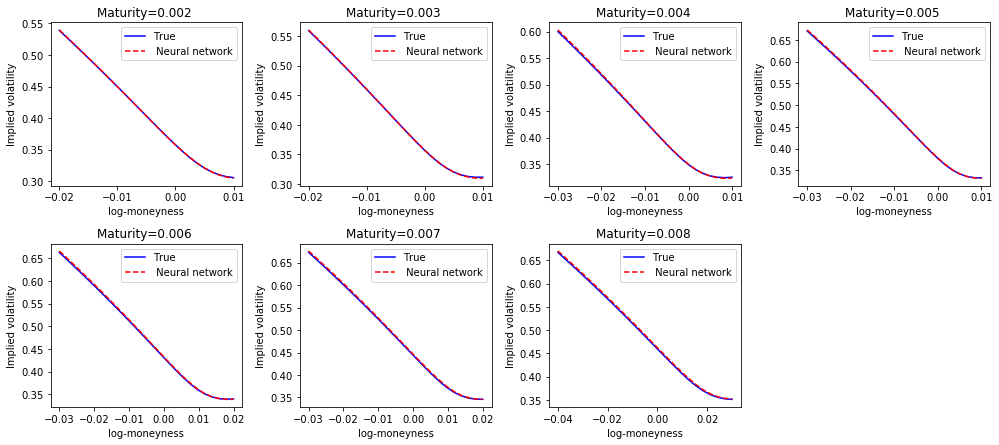

In [10]:
for key, value in models.items():
    model = keras.models.load_model(wd + '/data/neural_network_weights/rbergomi/rbergomi_model_5_' + key + '.h5', 
                                    custom_objects={'root_mean_squared_error': root_mean_squared_error, 'QHAdam': QHAdam, 'AdamW' : AdamW})
    # Specify test sample to plot:
    sample_ind = 5006

    # Print parameters of test sample:
    print("Model Parameters (H,eta,rho,xi1,xi2,...): ",myinverse(x_valid_mod[sample_ind,:]))

    import scipy, matplotlib.pyplot as plt 
    npts = 25
    x_sample = x_valid_mod[sample_ind,:]
    y_sample = y_valid_mod[sample_ind,:]

    prediction = scale_y.inverse_transform(model.predict(x_valid_mod))
    plt.figure(1,figsize=(14,12))
    j = -1
    for i in range(0,7):
        j = j + 1
        plt.subplot(4,4,j+1)

        plt.plot(logMoneyness[i*npts:(i+1)*npts],y_valid[sample_ind,i*npts:(i+1)*npts],'b',label="True")
        plt.plot(logMoneyness[i*npts:(i+1)*npts],prediction[sample_ind,i*npts:(i+1)*npts],'--r',label=" Neural network")

        plt.title("Maturity=%1.3f "%expiries[i*npts])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied volatility")

        plt.legend()
    plt.tight_layout()
    plt.show()

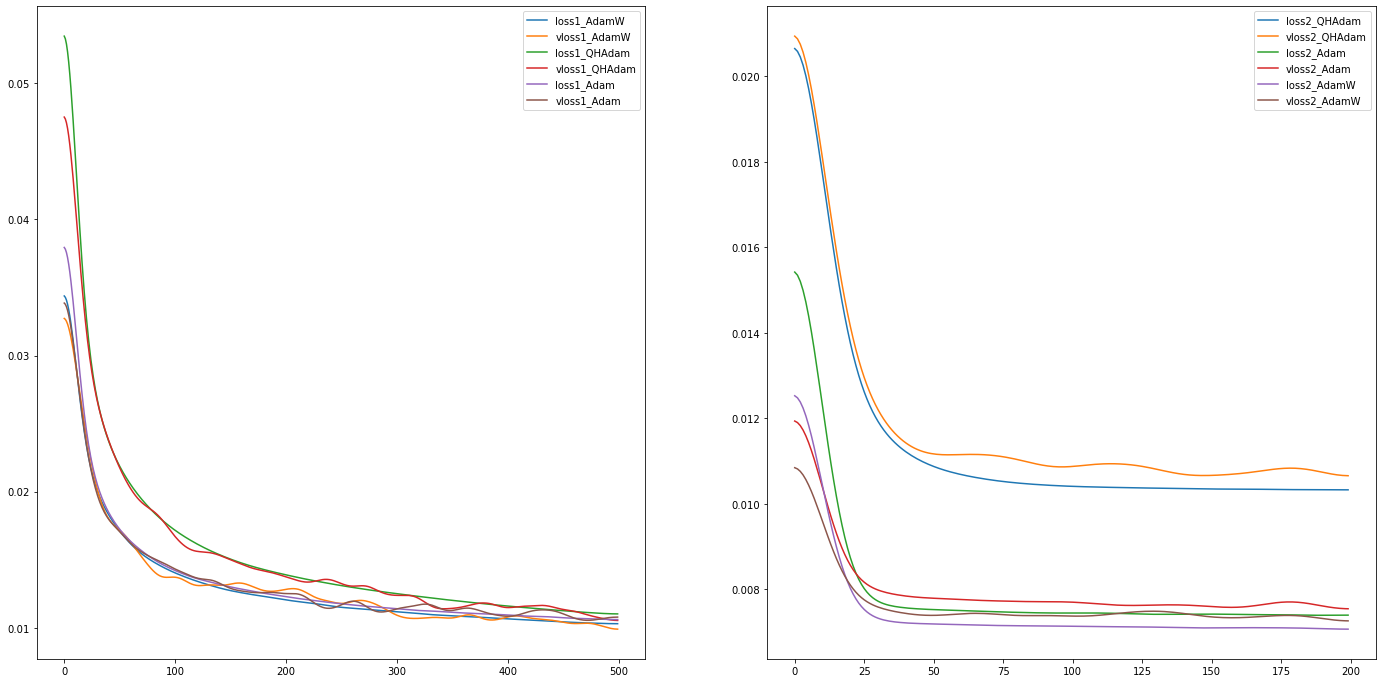

In [11]:
import pandas as pd
import glob
from scipy.ndimage.filters import gaussian_filter1d

fig, ax = plt.subplots(1, 2)

for i in range(1,3):
    path = wd + '/data/neural_network_weights/rbergomi/'
    all_files = glob.glob(path + "/*5*loss" + str(i) + ".csv")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename)
        df.iloc[:, 1:2] = gaussian_filter1d(df.iloc[:,1:2].T, sigma=10).T
        df.iloc[:, 0:1] = gaussian_filter1d(df.iloc[:,0:1].T, sigma=10).T
        li.append(df)

    frame = pd.concat(li, axis=1)
    frame.plot(figsize=(24,12), ax = ax[i-1])
    #plt.yscale("log")
